# Using traitlets to generate and modify maps of surface weather station data

In [1]:
from metpy.mapping.mpmap_traitlets import MetpyMap

from metpy.io.gini import GiniFile
from metpy.cbook import get_test_data, get_test_data_path
from metpy.plots.ctables import registry

import cartopy.crs as ccrs

to_proj = ccrs.AlbersEqualArea(central_longitude=-97.0000, central_latitude=38.0000)

MetpyMap is an object that contains all of the options, data, and logic to plot meteorological data on a map.

It inherits from "Application", a traitlets type that:

1) Can enforce property data types and throw exceptions if these conditions are not met.

2) Contains a flag that will allow users to modify default object attributes via a configuration file.

Setting up the configuration file is straightforward as long as information about object attributes are known.

The following code just loads the configuration file and displays it.  

The configuration file for this example is located in the testdata folder.

In [2]:
print(get_test_data_path('config_map.py'))

C:\Users\Alex\Documents\GitHub\MetPy\metpy\..\testdata\config_map.py


The following is the configuration file and the current parameter values.

In [3]:
with open(get_test_data_path('config_map.py'), 'r') as f:
    p_file = f.read()

print(p_file)

import cartopy.crs as ccrs


# Variables

file_location = "station_data.txt"

to_proj = ccrs.AlbersEqualArea(central_longitude=-97.0000, central_latitude=38.0000)
from_proj = ccrs.Geodetic()

north = 45
south = 30
east = -100
west = -120

oceans = True
borders = True
coastline = True
lakes = False
states = True

map_type = 'station'

# Map configuration
# Dict types only take dict assignments..
# cannot assign value to individual keys

c.MetpyMap.file_location = file_location

c.MetpyMap.map_type = map_type

c.MetpyMap.bbox = dict(north=40, south=25, east=-80, west=-100)

c.MetpyMap.projection_options = dict(to_proj=to_proj, from_proj=from_proj)

c.MetpyMap.features = dict(OCEANS=oceans, BORDERS=borders,
                           COASTLINE=coastline, LAKES=lakes, STATES=states)




Based on these values, we can instantiate a MetpyMap object and plot the given geographic information with very little code outside of the configuration file.

The following property changed: bbox
The following property changed: features
The following property changed: data


C:\Users\Alex\Anaconda3\lib\site-packages\traitlets\traitlets.py:540: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  silent = bool(old_value == new_value)


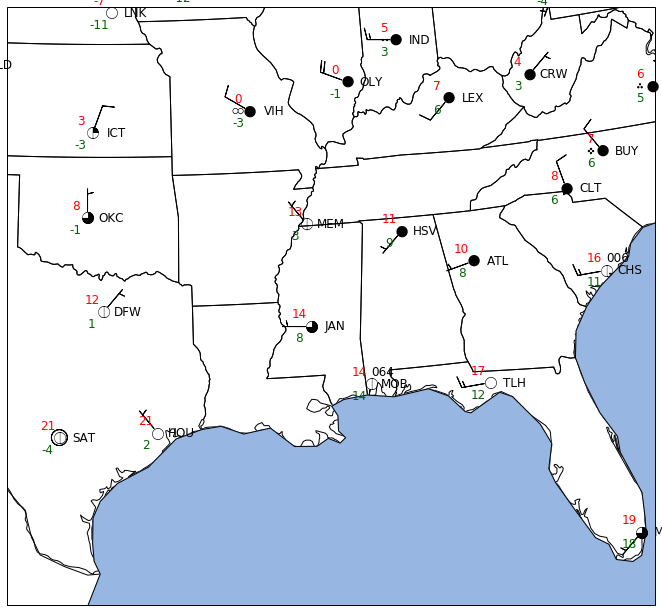

In [4]:
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
%matplotlib inline
plt.rcParams['figure.figsize'] = (9, 9)

fig = plt.figure()

view = plt.axes([0, 0, 1, 1], projection=to_proj)

sp = MetpyMap()

sp.view = view

sp.load_config_file(get_test_data_path('config_map.py'))

sp.load_text()

sp.draw_map()

We can directly access the object and modify attributes.

This example changes the bounding box dictionary of the map.

The following property changed: bbox


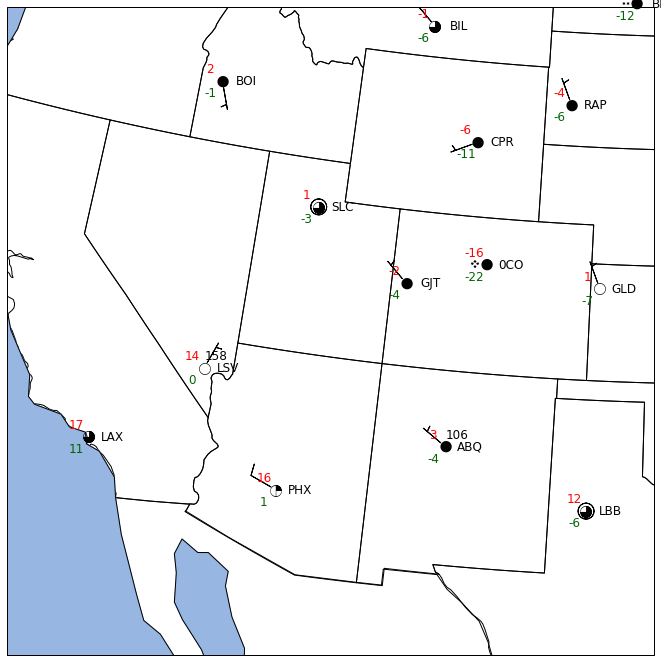

In [5]:
sp.bbox = dict(west=-120, east=-100, south=30, north=45)

display(fig)

What is nice about traitlets is you can enforce types for object attributes. 

For example, the following is the definition for the bounding box (bbox) property of MetpyMap.

In [6]:
from traitlets import Dict, Float

bbox = Dict(traits={"east": Float(allow_none=False), "west": Float(allow_none=False),
                    "north": Float(allow_none=False), "south": Float(allow_none=False)},
            help='map bounding box in lat/lon coordinates').tag(config=True)

bbox = None

This forces bbox to only take a dictionary, and if any of the four keywords are assigned (east, west, north, south), they must be floating point numbers.

In [22]:
from traitlets import TraitError

try:
    sp.bbox = dict(west=str(-120), east=-100, south=30, north=45)
except TraitError as e:
    print(e[0])

AttributeError: 'NoneType' object has no attribute 'info'

You can also use interact to update the object properties.

In [8]:
import copy

orig_dirs = copy.deepcopy(sp.data['wind_dir'])
orig_temps = copy.deepcopy(sp.data['air_temperature'])

The following property changed: bbox


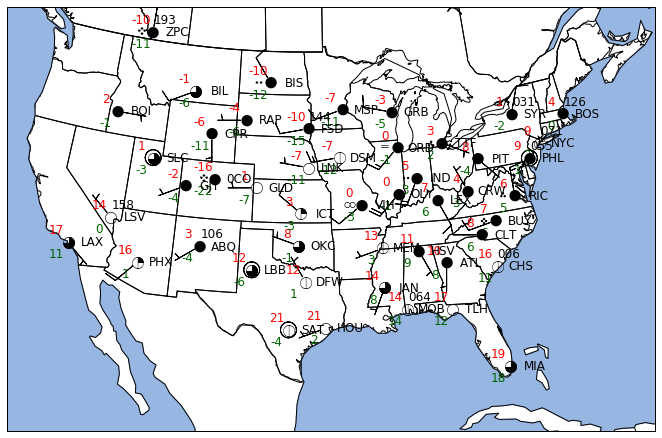

In [10]:
from traitlets import All
from ipywidgets import interact, IntSlider, Checkbox, SelectMultiple, Select, Button
from ipywidgets.widgets.widget_box import HBox, VBox
from IPython.display import display

def activate_features(container):
    
    t = copy.deepcopy(sp.features)
    
    if t[container.description.upper()]:
        container.background_color = 'White'
        t[container.description.upper()] = False
    else:
        container.background_color = 'LightGray'
        t[container.description.upper()] = True
    
    clear_output()
    sp.features = t
    display(fig)
    

def update_bbox(slider):
    
    t = copy.deepcopy(sp.bbox)
    
    skey = slider['owner'].description
    sval = slider['new']

    t[skey] = sval
    
    clear_output()
    sp.bbox = t
    display(fig)
    
def update_data(slider):

    t = copy.deepcopy(sp.data)
    
    skey = slider['owner'].description
    sval = slider['new']
    
    if skey == "air_temperature":
        t[skey] = orig_temps + sval
    elif skey == "wind_dir":
        t[skey] = (orig_dirs + sval) % 360
    
    clear_output()
    sp.data = t
    display(fig)
    
    
coastline = Button(description='Coastline', background_color='LightGray', value=True)
coastline.on_click(activate_features)

lakes = Button(description='Lakes', background_color='LightGray', value=True)
lakes.on_click(activate_features)

states = Button(description='States', background_color='LightGray', value=True)
states.on_click(activate_features)

borders = Button(description='Borders', background_color='LightGray', value=True)
borders.on_click(activate_features)

oceans = Button(description='Oceans', background_color='LightGray', value=True)
oceans.on_click(activate_features)

hbuttons = HBox(children=[coastline, lakes, states, borders, oceans])


east = IntSlider(min=-120, max=-60, step=5, value=-70, continuous_update=False, description='east')
east.observe(update_bbox, names='value')

west = IntSlider(min=-120, max=-60, step=5, value=-120, continuous_update=False, description='west')
west.observe(update_bbox, names='value')

north = IntSlider(min=20, max=50, step=5, value=50, continuous_update=False, description='north')
north.observe(update_bbox, names='value')

south = IntSlider(min=20, max=50, step=5, value=20, continuous_update=False, description='south')
south.observe(update_bbox, names='value')

sp.bbox = dict(east=-70, west=-120, south=20, north=50)

wind_dir_offset = IntSlider(min=-180, max=180, step=10, value=0, continuous_update=False, description="wind_dir")
wind_dir_offset.observe(update_data, names='value')

temp_offset = IntSlider(min=-20, max=20, step=2, value=0, continuous_update=False, description="air_temperature")
temp_offset.observe(update_data, names='value')

vsliders = VBox(children=[east, west, north, south])

    
display(fig)
    
display(hbuttons)

display(vsliders)

display(wind_dir_offset)

display(temp_offset)